# Using Machine Learning to Create Price Prediction for Tokyo Based Real Estate Company with Python

## Part B: Correlation Analysis and Machine Learning Modeling 

##### By Shahin Karami

This Notebook contains the second part of this project. The previous part consisted of data prep and exploratory data analysis (EDA). The focus of this Notebook is to conduct Correlation Analysis using variables outlined in the previous part, along with building and running a Supervised ML model using `PyCaret`. Once the ML model is created, model analysis is conducted. As with the previous notebook, this notebook will also be split up into 2 steps: Correlation Analysis and Machine Learning Modeling
<hr>

## Step 1: Correlation Analysis

After importing the necessary packages and the data, I am going to explore the relationship between the variables and the price. Since price is arguably the key factor for each piece of real estate, it makes sense to examine how many other factors are correlated with it. To accomplish this, I will consider two different methods. The first method involves analyzing the correlation between numeric variables and `price`, while the second method involves exploring the correlation between categorical variables and `price`. For numerical variables, I will use Pearson correlation, and for categorical variables, I will use ANOVA.

### 1 - Imports and Data Import via `pickle`

In [1]:
import pickle
import matplotlib
import json

import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.pyplot import figure

plt.style.use('ggplot')
%matplotlib inline

from pycaret.regression import *

In [2]:
with open('TokyoSub_Final.pickle', 'rb') as file:
    df = pickle.load(file)

df

,Type,Municipality,MinuteToClosestStation,Price,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation
5,Residential Land(Land and Building),Chiyoda Ward,4.0,120000000,1K,65,Semi-rectangular Shaped,6.5,1970.0,S,House,South,Not yet
18,Residential Land(Land and Building),Chiyoda Ward,3.0,240000000,1K,80,Semi-trapezoidal Shaped,6.8,1986.0,RC,House,Southwest,Not yet
30,Residential Land(Land and Building),Chiyoda Ward,5.0,300000000,1K,210,Semi-rectangular Shaped,13.0,1982.0,RC,Other,Northeast,Not yet
31,Residential Land(Land and Building),Chiyoda Ward,4.0,170000000,1K,105,Semi-rectangular Shaped,6.8,1970.0,RC,Office,Northeast,Not yet
90,Residential Land(Land and Building),Chiyoda Ward,4.0,1600000000,1K,640,Trapezoidal Shaped,35.0,1985.0,RC,Office,South,Not yet
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19954,Residential Land(Land and Building),Bunkyo Ward,4.0,9000000,1K,35,Rectangular Shaped,3.7,1945.0,W,House,East,Not yet
19956,Residential Land(Land and Building),Minato Ward,1.0,530000000,1K,230,Semi-trapezoidal Shaped,10.0,1980.0,SRC,Office,Northeast,Not yet
19975,Residential Land(Land and Building),Minato Ward,16.0,110000000,1K,85,Semi-square Shaped,8.0,1995.0,W,House,Southwest,Not yet
19988,Residential Land(Land and Building),Bunkyo Ward,6.0,40000000,1K,30,Rectangular Shaped,3.0,2000.0,W,House,North,Not yet


<hr>

### 2 - Pearson Correlation

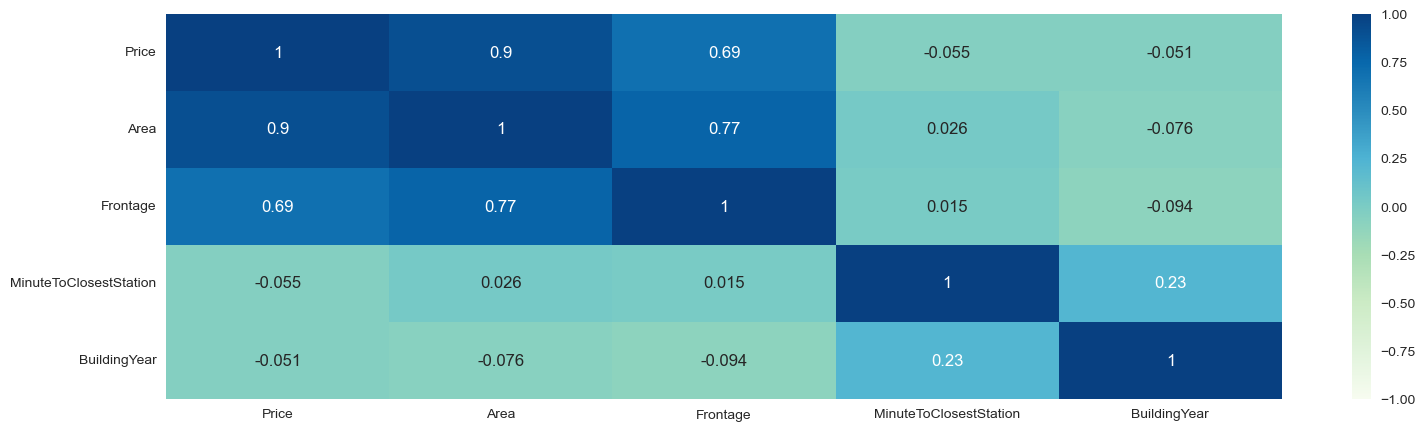

In [3]:
pearson_cor = df[['Price','Area','Frontage','MinuteToClosestStation','BuildingYear']].corr(method = 'pearson')

plt.figure(figsize = (18,5))

sns.heatmap(pearson_cor,
            vmin = -1,
            vmax = 1,
            cmap = "GnBu",
            annot = True)
plt.show()

Above is the Pearson Correlation matrix for all the numerical variables. Note that `Price` is positively correlated with `Area` and `Frontage`. This is to be expected since properties with more land tend to be more valuable. The most interesting correlation—or rather, the lack thereof—is between the distance to the nearest station and the age of the building. One would naturally assume that property owners, especially homeowners, in Tokyo would value properties near a train station, thus inflating their prices. However, there is almost no correlation between price and distance. Similarly, the age of a property does not correlate with its price. This suggests that property age and distance to the nearest station have no relationship with the price

To visualize the correlations, I created four plots, each representing a variable with respect to price. For each plot, I fitted an OLS regression line to the data. The correlation coefficient determines the slope of the fitted line. When the correlation coefficient is closer to 1.0, the slope of the line is steeper. Conversely, when the correlation coefficient is closer to 0.0, the slope is flatter. The plots below visualize the results of the Pearson Correlation matrix above.

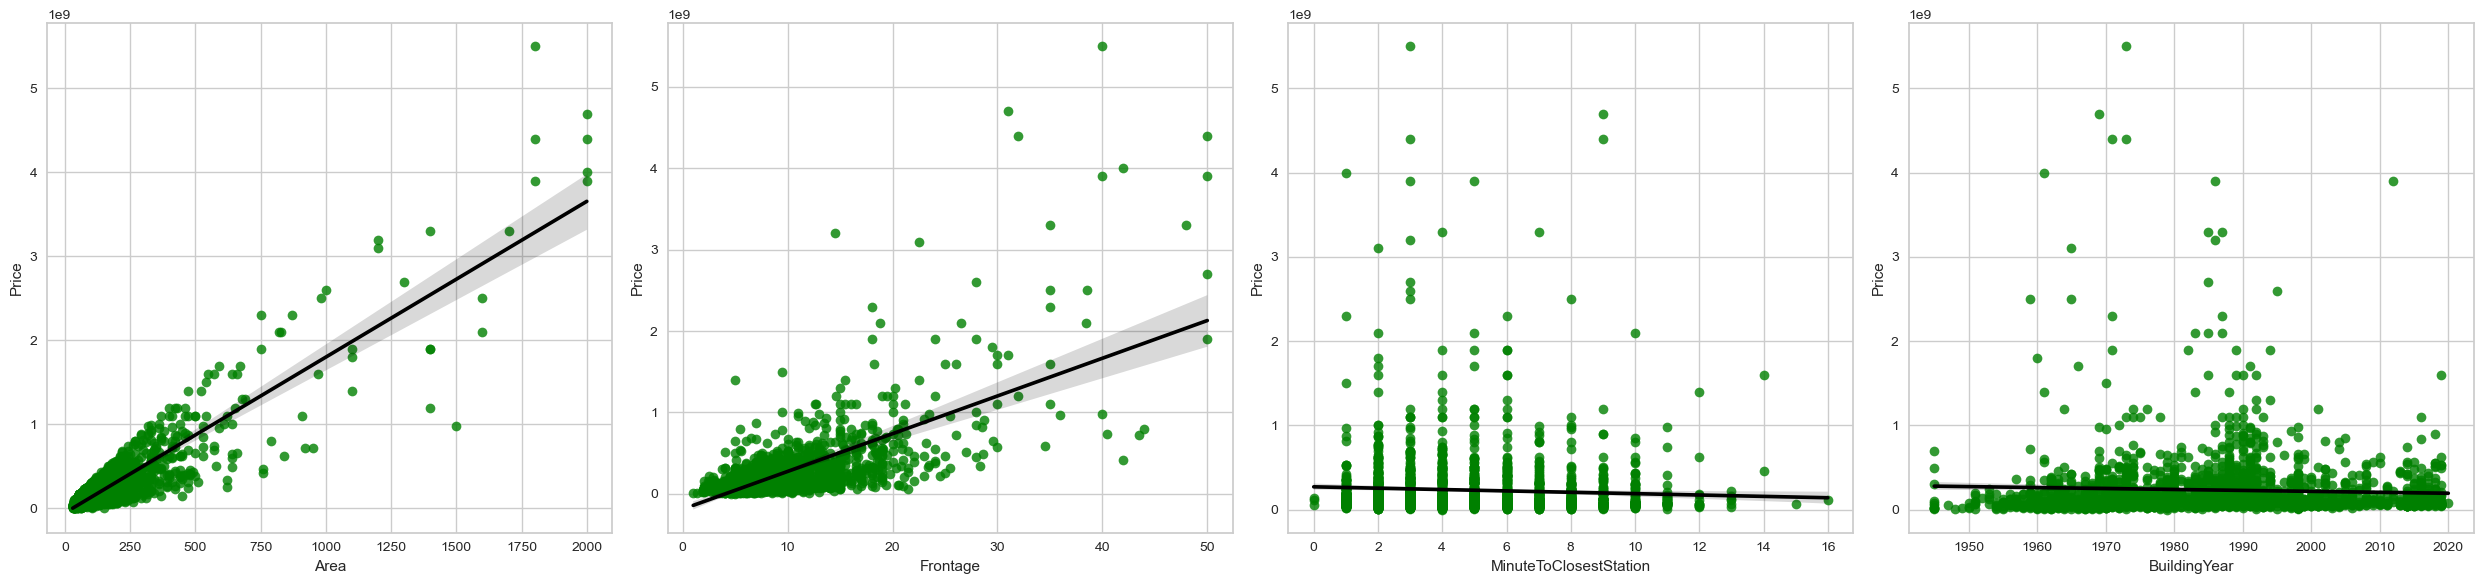

In [4]:
#declare numeric variable
numeric = ['Area','Frontage','MinuteToClosestStation','BuildingYear']

# Create a grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(25, 6))

# Flatten the axes array to make it 1D
axes = axes.ravel()

# Loop through each subplot and plot sns.regplot
for i, col in enumerate(numeric):
    sns.regplot(x = col, y='Price', data = df ,ax = axes[i], scatter_kws = {"color": "green"}, line_kws={"color":"black"})
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

<hr>

### 3 - ANOVA Test

For categorical variables, my first step is to check whether a particular categorical variable impacts the price significantly or not. To do this, I run an ANOVA test to compare the differences between means. After that, for significant variables, I conduct a descriptive analysis for all labels within the particular categorical variable and then compare their impacts on the price. I will omit `Renovation`, `FloorPlan`, and `Type` from the pairwise descriptive analysis as each of these variables only has one unique value.

In [5]:
cat_list = ['Municipality', 'LandShape', 'Structure', 'Use', 'Direction']

for i in cat_list:
    formula = 'Price ~ {}'.format(i)
    model = ols(formula, data=df).fit()
    anova = sm.stats.anova_lm(model, typ=2, robust = 'hc3')
    p_value = anova.iloc[0,3]

    print('P-value for Price ~ {}: {}'.format(i , p_value))

P-value for Price ~ Municipality: 1.244738946240639e-10
P-value for Price ~ LandShape: 1.5745395046513997e-17
P-value for Price ~ Structure: 1.0219039791033004e-77
P-value for Price ~ Use: 8.04871268698268e-26
P-value for Price ~ Direction: 3.7488561007703056e-80


The results above show that all categorical variables are significant in explaining the price of real estate (P-value < 0.05), leading to the rejection of the null hypothesis. In the next step, I aim to determine which label in the above categorical variables has the greatest impact on price. To achieve this, I create a function to calculate the mean for each label within every single categorical variable. This approach will provide a clear picture of how categorical characteristics affect the price of real estate.

In [6]:
def mean_pairwise(cat_var):
    mean_by = df.groupby(cat_var)['Price'].mean()
    mean_by = pd.DataFrame(mean_by)
    mean_by = mean_by.sort_values(by=['Price'], inplace=False, ascending=False)
    
    return mean_by

In [7]:
mean_pairwise('Municipality')

,Price
Municipality,
Minato Ward,3.435867e+08
Chiyoda Ward,2.814054e+08
Chuo Ward,2.189682e+08
Bunkyo Ward,1.864118e+08
Shinjuku Ward,1.706380e+08


In [8]:
mean_pairwise('LandShape')

,Price
LandShape,
Irregular Shaped,4.086514e+08
Semi-shaped,3.117000e+08
Trapezoidal Shaped,2.869474e+08
Other LandShape,2.400000e+08
Semi-trapezoidal Shaped,2.209007e+08
Semi-rectangular Shaped,2.034132e+08
Semi-square Shaped,1.981786e+08
Square Shaped,1.762941e+08
Rectangular Shaped,1.758670e+08


In [9]:
mean_pairwise('Structure')

,Price
Structure,
SRC,6.090839e+08
RC,3.503991e+08
S,1.641401e+08
LS,1.251042e+08
W,8.214610e+07
B,5.766667e+07


In [10]:
mean_pairwise('Use')

,Price
Use,
Other,5.792000e+08
Warehouse,4.950833e+08
Office,3.877884e+08
Housing Complex,2.924059e+08
Shop,2.808986e+08
Factory,1.777500e+08
House,1.381165e+08
Workshop,1.302500e+08


In [11]:
mean_pairwise('Direction')

,Price
Direction,
Northwest,2.732897e+08
Southeast,2.608280e+08
Northeast,2.320756e+08
West,2.315943e+08
North,2.297664e+08
Southwest,2.256248e+08
East,2.063345e+08
South,1.975000e+08
No facing road,2.478750e+07


<hr>

## Step 2: Building the Regresion Model

Now I will use build a regression model using the `PyCaret` package.

### 1 - Feature Declaration

I begin with declaring all features based on their type.

In [12]:
num_f = ['MinuteToClosestStation', 'Area' , 'Frontage', 'BuildingYear']

cat_f = ['Type', 'Municipality', 'FloorPlan', 'LandShape', 'Structure', 'Use', 'Direction', 'Renovation']

<hr>

### 2 - Model Setup

I set up the regressor, model target, and data split.

In [15]:
reg = setup(
    #Model Selection
    data = df,    target = 'Price',    train_size = 0.75,    fold = 10,    session_id = 19907,
    
    #Data Types
    numeric_features = num_f,    categorical_features = cat_f,    ignore_features = None)

,Description,Value
0,Session id,19907
1,Target,Price
2,Target type,Regression
3,Original data shape,"(2108, 13)"
4,Transformed data shape,"(2108, 46)"
5,Transformed train set shape,"(1581, 46)"
6,Transformed test set shape,"(527, 46)"
7,Numeric features,4
8,Categorical features,8
9,Preprocess,True


<hr>

### 3 - Model Comparison, Selection, and Training

Now, I run multiple different Machine Leraning models to determine the optimal model--based on RSME. I find that a Gradiant Boosting Regressor Model will be the most optimal model for the real estate data. 

In [16]:
compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,68911659.8578,19259832008996756.0000,137360564.2537,0.8507,0.4683,0.4876,0.9190
rf,Random Forest Regressor,70697907.0516,19627170822730428.0000,139406800.6194,0.8502,0.4686,0.4996,1.1310
et,Extra Trees Regressor,72799348.4237,20354123367315708.0000,141698068.0860,0.8470,0.4797,0.5088,1.0240
xgboost,Extreme Gradient Boosting,72680613.5936,22571305760493688.0000,149168312.2651,0.8296,0.4952,0.4996,1.0020
ridge,Ridge Regression,88732875.8318,24950862610899216.0000,155660656.3434,0.8155,0.8921,0.8535,0.7640
llar,Lasso Least Angle Regression,88871519.6259,25004960999073504.0000,155823540.7895,0.8152,0.8787,0.8550,0.6460
lasso,Lasso Regression,88879323.0676,25006160077303712.0000,155827165.5617,0.8152,0.8787,0.8551,0.8580
en,Elastic Net,88938523.8367,25249900418238568.0000,156439842.3381,0.8124,0.7874,0.7699,0.6400
omp,Orthogonal Matching Pursuit,91662406.4268,25351970008235276.0000,157001579.0608,0.8110,0.8556,0.8242,0.6870
huber,Huber Regressor,88870193.5624,29671431287072508.0000,168754889.7742,0.7972,0.5820,0.6310,0.6680


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

GradientBoostingRegressor(random_state=19907)

Now I create the Gradient Boosting Regressor model:

In [18]:
reg_gbf = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,62006234.2573,19427766992284996.0000,139383524.8237,0.8260,0.3915,0.3166
1,64449622.2801,13740488909276138.0000,117219831.5528,0.8303,0.4594,0.4252
2,69085764.3071,23962343086408148.0000,154797748.9707,0.8688,0.4481,0.3955
3,68653152.9192,21844780506250792.0000,147799798.7355,0.7601,0.5254,0.6255
4,71230386.2928,26490352712437312.0000,162758571.8555,0.8961,0.3890,0.3691
5,68019683.8437,15243548424339896.0000,123464765.9227,0.9442,0.4734,0.4409
6,75477279.9737,21107898196078244.0000,145285574.6318,0.8772,0.4865,0.4797
7,79891084.7308,25324743292267292.0000,159137498.0709,0.6623,0.6093,1.0034
8,72408980.4230,15980414100936862.0000,126413662.6356,0.9044,0.4550,0.3988


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

<hr>

### 4 - Hyper-parameter Tunning

Now I can hyper tune and optimze the Gradiant Boosting Regressor to find a potential stronger model.

<b>RMSE (Mean Squared Error)</b></br></br>
<i> The Root Mean Squared Error measures the average root squared difference between the predicted and actual values. It is calculated by taking the square of the difference between the predicted and actual values for each data point, and then taking the mean of these root squared differences. A smaller value of RMSE indicates better performance, as it means the model's predictions are closer to the actual values on average. In the table, the model with the lowest RMSE (135,193,045.1611) indicates that the model's predictions are off by around 135,193,045 Yen root squared from the actual values.</i>

<b>R2 (R-squared)</b>  </br></br>
<i> The coefficient of determination, or R-squared, measures the proportion of variance in the target variable that can be explained by the independent variables in the model. An R-squared value of 1 indicates a perfect fit, meaning all the variance in the target variable is explained by the independent variables in the model. On the other hand, an R-squared value of 0 indicates that the model does not explain any of the variance in the target variable. In the table, the model with the highest R-squared (0.8181) indicates that around 81.81% of the variance in the target variable can be explained by the independent variables in the model. </i>

In [19]:
tuned_reg_gbf = tune_model(reg_gbf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,64795263.7668,22909130484171188.0000,151357624.4666,0.7948,0.4115,0.3309
1,66697820.1170,15499245618951110.0000,124495966.2758,0.8086,0.4121,0.3767
2,69595169.4635,25189466915659056.0000,158711899.0992,0.8621,0.4132,0.3690
3,65922587.2660,20510747830340356.0000,143215738.7662,0.7747,0.5185,0.5740
4,71414120.1244,27369502935639644.0000,165437308.1733,0.8926,0.4111,0.3782
5,67617701.6390,14711066261418062.0000,121289184.4371,0.9461,0.4924,0.4298
6,73789379.0185,21156202602230572.0000,145451719.1450,0.8769,0.4749,0.4691
7,78117346.8869,24720172834651032.0000,157226501.6931,0.6704,0.5958,1.0062
8,71067232.2593,16047743201894938.0000,126679687.4084,0.9040,0.4500,0.3888


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Tuning the Gradient did not yield a stronger model--thus the original model will be used moving forward. 

<hr>

### 5 - Model Analysis

Now, I can analyze the performance of trained model on test set.

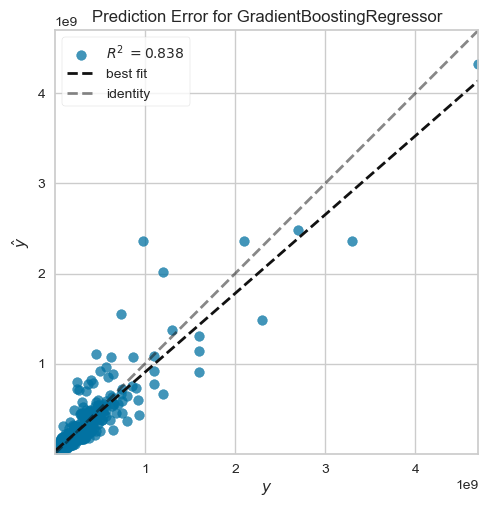

In [20]:
plot_model(tuned_reg_gbf, plot = 'error')

A Prediction Error plot is a graphical representation of the difference between the actual price and the predicted price of a regression model. It is a useful way to understand the distribution and magnitude of the errors made by the model across the range of price values.  Data scientists can diagnose regression models using this plot by comparing against the 45 degree line (Identity), where the prediction exactly matches the model. The plot for the GBR model will show the predicted price (x-axis) versus the difference between the actual values (y-axis). Since the errors are evenly distributed around zero and have no apparent pattern or trend, it suggests that the GBR model has accurately predicted the price values.

<hr>

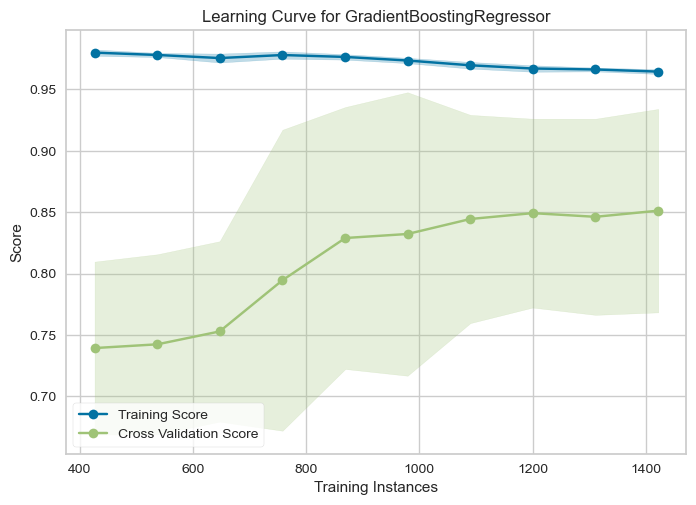

In [21]:
plot_model(tuned_reg_gbf, plot = 'learning')

Learning curves are plots used to show a model's performance as the training set size increases. They can also display the model's performance over a defined period of time. Learning curves are a useful tool for understanding the bias-variance tradeoff of a model and identifying whether the model is underfitting or overfitting the data.

The validation score typically increases with the number of training samples but eventually reaches a plateau, indicating that the model is not overfitting the data. As the gap between the training and validation scores becomes small and stable, it indicates that the model is achieving a good balance and is neither overfitting nor underfitting the data.

<hr>

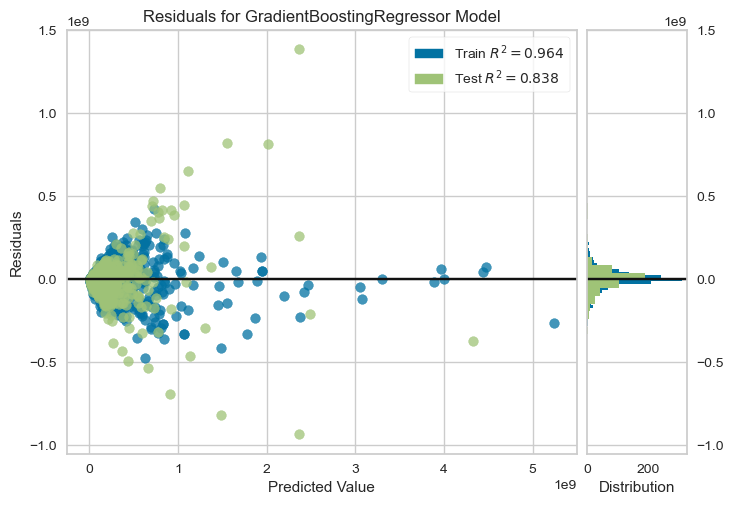

In [22]:
plot_model(tuned_reg_gbf, plot = 'residuals')

A residual plot is a scatterplot that displays the residuals on the vertical axis and the predicted values on the horizontal axis. Residual plots help determine whether a given model is appropriate for modeling the given data. Ideally, a residual plot should exhibit no clear trend and a lack of heteroskedasticity.

In this plot, both the training and testing data clearly do not exhibit any pattern. However, while the training data shows a rather tight residual spread, the testing set exhibits varying magnitudes as the predicted value increases.

<hr>

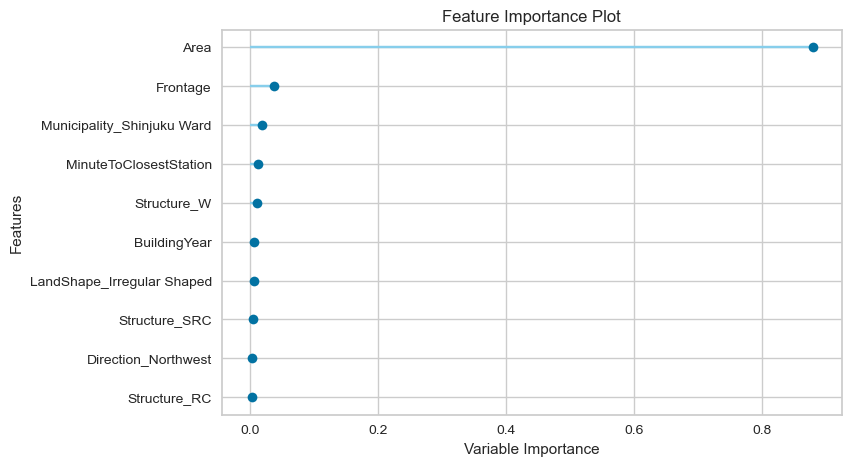

In [23]:
plot_model(tuned_reg_gbf, plot = 'feature')

A Feature Importance Plot is a graphical representation of the relative importance of the predictor variables in a regression model. It's a useful way to understand the contribution of each variable to the prediction of the price. This plot shows the `Area` is by far the most important feature to predict the price of house. Naturally, this makes sense in the context of the real state industry.

<hr>

### 6 - Finalize the Model

Now, we run the trained model on test to see the result.

In [26]:
predict_model(tuned_reg_gbf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,73909492.8351,22221867178801316.0000,149070007.6434,0.8377,0.4820,0.6905


,Type,Municipality,MinuteToClosestStation,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation,Price,prediction_label
17991,Residential Land(Land and Building),Chuo Ward,2.0,1K,260,Semi-shaped,17.0,1987.0,SRC,Office,North,Not yet,750000000,5.806261e+08
30,Residential Land(Land and Building),Chiyoda Ward,5.0,1K,210,Semi-rectangular Shaped,13.0,1982.0,RC,Other,Northeast,Not yet,300000000,3.794128e+08
9846,Residential Land(Land and Building),Minato Ward,3.0,1K,40,Rectangular Shaped,5.0,1971.0,S,House,North,Not yet,100000000,7.373645e+07
15645,Residential Land(Land and Building),Shinjuku Ward,7.0,1K,45,Rectangular Shaped,5.5,2014.0,W,House,Northwest,Not yet,42000000,5.246016e+07
14786,Residential Land(Land and Building),Shinjuku Ward,8.0,1K,70,Rectangular Shaped,6.5,1968.0,W,Housing Complex,South,Not yet,30000000,2.472405e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15012,Residential Land(Land and Building),Minato Ward,4.0,1K,90,Semi-square Shaped,9.0,1983.0,RC,House,East,Not yet,150000000,1.568907e+08
16319,Residential Land(Land and Building),Shinjuku Ward,9.0,1K,85,Semi-rectangular Shaped,5.5,1980.0,RC,House,North,Not yet,140000000,9.451796e+07
14593,Residential Land(Land and Building),Shinjuku Ward,6.0,1K,60,Semi-trapezoidal Shaped,2.2,2014.0,W,House,East,Not yet,52000000,4.913597e+07
16409,Residential Land(Land and Building),Chuo Ward,4.0,1K,80,Rectangular Shaped,6.2,1989.0,S,Office,Northwest,Not yet,240000000,1.444294e+08


Now we finalize the model. The purpose of this function is to train the model on the complete dataset before it is deployed in production. This is done this to train the model on the entire dataset (including the test set) and prepare the model for deployment. The function takes a trained model object and additional parameters and returns a finalized model object that is ready to be used for making predictions on new data.

In [27]:
final = finalize_model(tuned_reg_gbf)
final

Pipeline(memory=FastMemory(location=C:\Users\19168\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['MinuteToClosestStation', 'Area',
                                             'Frontage', 'BuildingYear'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['Type', 'Municipality',
                                             'FloorPlan', 'LandShape',
                                             'Structure', 'Use', 'Direction',...
                 TransformerWrapper(include=['Type', 'Municipality',
                                             'FloorPlan', 'LandShape',
                                             'Structure', 'Use', 'Direction',
                                             'Renovation'],
                                    transformer=OneHotEncoder(cols=['Type',
                                                                    'Municipality',
                                                                    'FloorPlan',
                                                                    'LandShape',
                                                                    'Structure',
                                                                    'Use',
                                                                    'Direction',
                                                                    'Renovation'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('actual_estimator',
                 GradientBoostingRegressor(random_state=19907))])

Now that the model is finalized, I can rerun it with the complete dataset before saving it for deployment. As expected, the R2 has increased, and the RMSE has decreased. This improvement is because the final model is trained on the complete dataset, which includes the test set.

In [28]:
predict_model(final, data = df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,52913530.7619,7162347678709238.0000,84630654.4859,0.9527,0.4478,0.5059


,Type,Municipality,MinuteToClosestStation,FloorPlan,Area,LandShape,Frontage,BuildingYear,Structure,Use,Direction,Renovation,Price,prediction_label
5,Residential Land(Land and Building),Chiyoda Ward,4.0,1K,65,Semi-rectangular Shaped,6.5,1970.0,S,House,South,Not yet,120000000,9.459073e+07
18,Residential Land(Land and Building),Chiyoda Ward,3.0,1K,80,Semi-trapezoidal Shaped,6.8,1986.0,RC,House,Southwest,Not yet,240000000,1.423926e+08
30,Residential Land(Land and Building),Chiyoda Ward,5.0,1K,210,Semi-rectangular Shaped,13.0,1982.0,RC,Other,Northeast,Not yet,300000000,3.874154e+08
31,Residential Land(Land and Building),Chiyoda Ward,4.0,1K,105,Semi-rectangular Shaped,6.8,1970.0,RC,Office,Northeast,Not yet,170000000,1.854143e+08
90,Residential Land(Land and Building),Chiyoda Ward,4.0,1K,640,Trapezoidal Shaped,35.0,1985.0,RC,Office,South,Not yet,1600000000,1.473689e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19954,Residential Land(Land and Building),Bunkyo Ward,4.0,1K,35,Rectangular Shaped,3.7,1945.0,W,House,East,Not yet,9000000,2.483551e+07
19956,Residential Land(Land and Building),Minato Ward,1.0,1K,230,Semi-trapezoidal Shaped,10.0,1980.0,SRC,Office,Northeast,Not yet,530000000,5.167918e+08
19975,Residential Land(Land and Building),Minato Ward,16.0,1K,85,Semi-square Shaped,8.0,1995.0,W,House,Southwest,Not yet,110000000,1.044334e+08
19988,Residential Land(Land and Building),Bunkyo Ward,6.0,1K,30,Rectangular Shaped,3.0,2000.0,W,House,North,Not yet,40000000,3.436293e+07


<hr>

### 7 - Final Comments and Saving the Model

In this notebook I have conducted correlation analysis which showed that the area and frontage are correlated with the price of real estate. I also break down the relationship of each categorical features with price. Using `PyCaret` package I identify the approprate ML model for the dataset--a stock Gradiant Boosting Regressor. I explore various aspects of the model and present my findings.

Lastly, I save the final model for any future prediction.

In [149]:
GBR_Model = save_model(final,'Final Regression Model')

Transformation Pipeline and Model Successfully Saved
